In [1]:
import sys
sys.path.append("/home/azhuavlev/PycharmProjects/ml-neuman_mano")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import glob
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch3d
import sys
import time
import torch
from IPython import display
from PIL import Image
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    NDCMultinomialRaysampler,
    MonteCarloRaysampler,
    EmissionAbsorptionRaymarcher,
    ImplicitRenderer,
    RayBundle,
    ray_bundle_to_ray_points,
)
# Data structures and functions for rendering
from pytorch3d.structures import Volumes
from pytorch3d.transforms import so3_exp_map
from tqdm import tqdm

from generate_cow_renders import generate_cow_renders
from plot_image_grid import image_grid

from helpers import *
from nerf import *

from data_io import neuman_helper

# obtain the utilized device
# if torch.cuda.is_available():
#     device = torch.device("cuda:0")
#     torch.cuda.set_device(device)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load the data

In [4]:
train_scene = neuman_helper.NeuManReader.read_scene(
    '/home/azhuavlev/Desktop/Data/InterHand_Neuman/02/',
    tgt_size=None,
    normalize=False,
    bkg_range_scale=3,
    human_range_scale=1.5,
    mask_dir='segmentations',
    smpl_type='optimized'
)

train_scene.read_data_to_ram(data_list=['image', 'depth'])

Rs = []
Ts = []
target_images, target_silhouettes = [], []
for i in range(len(train_scene.captures)):
    Rs.append(train_scene.captures[i].cam_pose.rotation_matrix[0:3, 0:3])
    Ts.append(train_scene.captures[i].cam_pose.translation_vector)

    # not normalized!
    target_images.append(train_scene.captures[i].image)
    target_silhouettes.append(train_scene.captures[i].mask)

R = torch.tensor(np.array(Rs))
T = torch.tensor(np.array(Ts))
target_images = torch.tensor(np.array(target_images))
target_silhouettes = torch.tensor(np.array(target_silhouettes))

target_images = (target_images.to(torch.float32) / 255.0).clamp(0.0, 1.0)
target_silhouettes = target_silhouettes.to(torch.float32)

print('R', R.shape)
print('T', T.shape)
print('target_images', target_images.shape, target_images.dtype, target_images)
print('target_silhouettes', target_silhouettes.shape, target_silhouettes.dtype, target_silhouettes)

cameras 60
images_meta 60
num_views 60
60 1
can not find mvs depth for 00000.png
can not find keypoints for 00000.png
can not find densepose for 00000.png
can not find mvs depth for 00001.png
can not find keypoints for 00001.png
can not find densepose for 00001.png
can not find mvs depth for 00002.png
can not find keypoints for 00002.png
can not find densepose for 00002.png
can not find mvs depth for 00003.png
can not find keypoints for 00003.png
can not find densepose for 00003.png
can not find mvs depth for 00004.png
can not find keypoints for 00004.png
can not find densepose for 00004.png
can not find mvs depth for 00005.png
can not find keypoints for 00005.png
can not find densepose for 00005.png
can not find mvs depth for 00006.png
can not find keypoints for 00006.png
can not find densepose for 00006.png
can not find mvs depth for 00007.png
can not find keypoints for 00007.png
can not find densepose for 00007.png
can not find mvs depth for 00008.png
can not find keypoints for 0000

Computing near/far for ['human']: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 2896.69it/s]


reading data, memory usage 156.56 MB: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 65.45it/s]


----- total memory usage: 156.56 MB -----
R torch.Size([60, 3, 3])
T torch.Size([60, 3])
target_images torch.Size([60, 512, 334, 3]) torch.float32 tensor([[[[0.0157, 0.0157, 0.0235],
          [0.0196, 0.0196, 0.0275],
          [0.0196, 0.0196, 0.0275],
          ...,
          [0.0392, 0.0392, 0.0392],
          [0.0353, 0.0353, 0.0353],
          [0.0353, 0.0353, 0.0431]],

         [[0.0157, 0.0157, 0.0235],
          [0.0196, 0.0196, 0.0275],
          [0.0235, 0.0235, 0.0314],
          ...,
          [0.0392, 0.0392, 0.0392],
          [0.0392, 0.0392, 0.0392],
          [0.0353, 0.0353, 0.0353]],

         [[0.0196, 0.0196, 0.0196],
          [0.0196, 0.0196, 0.0196],
          [0.0235, 0.0235, 0.0235],
          ...,
          [0.0353, 0.0353, 0.0353],
          [0.0353, 0.0353, 0.0353],
          [0.0353, 0.0353, 0.0353]],

         ...,

         [[0.0196, 0.0118, 0.0157],
          [0.0235, 0.0157, 0.0196],
          [0.0235, 0.0157, 0.0196],
          ...,
          [0.019

In [5]:
nears = []
fars = []
for i in range(len(train_scene.captures)):
    # print(train_scene.captures[i].near['human'], train_scene.captures[i].far['human'])
    nears.append(train_scene.captures[i].near['human'])
    fars.append(train_scene.captures[i].far['human'])

min_depth = min(nears)
volume_extent_world = max(fars)
print('min_depth', min_depth)
print('volume_extent_world', volume_extent_world)

min_depth 0.9200718870136456
volume_extent_world 1.330110787354322


# Set the camera parameters.

In [6]:
# Our rendered scene is centered around (0,0,0)
# and is enclosed inside a bounding box
# whose side is roughly equal to 3.0 (world units).
# min_depth = 0.01
# volume_extent_world = 2.0

target_cameras = FoVPerspectiveCameras(device=device, R=R, T=T, znear=min_depth, zfar=volume_extent_world)

# target_cameras, target_images, target_silhouettes = generate_cow_renders(num_views=40, azimuth_range=180)
print(f'Generated {len(target_images)} images/silhouettes/cameras.')

# render_size describes the size of both sides of the
# rendered images in pixels. Since an advantage of
# Neural Radiance Fields are high quality renders
# with a significant amount of details, we render
# the implicit function at double the size of
# target images.
render_size_x = target_images.shape[1] //2
render_size_y = target_images.shape[2] // 2

Generated 60 images/silhouettes/cameras.


# Instantiate the raysamplers.

In [7]:
# Here, NDCMultinomialRaysampler generates a rectangular image
# grid of rays whose coordinates follow the PyTorch3D
# coordinate conventions.
raysampler_grid = NDCMultinomialRaysampler(
    image_height=render_size_x,
    image_width=render_size_y,
    n_pts_per_ray=32,
    min_depth=min_depth,
    max_depth=volume_extent_world,
)

# MonteCarloRaysampler generates a random subset
# of `n_rays_per_image` rays emitted from the image plane.
raysampler_mc = MonteCarloRaysampler(
    min_x=-1.0,
    max_x=1.0,
    min_y=-1.0,
    max_y=1.0,
    n_rays_per_image=2048,
    n_pts_per_ray=32,
    min_depth=min_depth,
    max_depth=volume_extent_world,
)

# 2) Instantiate the raymarcher.
# Here, we use the standard EmissionAbsorptionRaymarcher
# which marches along each ray in order to render
# the ray into a single 3D color vector
# and an opacity scalar.
raymarcher = EmissionAbsorptionRaymarcher()

# Finally, instantiate the implicit renders
# for both raysamplers.
renderer_grid = ImplicitRenderer(
    raysampler=raysampler_grid, raymarcher=raymarcher,
)
renderer_mc = ImplicitRenderer(
    raysampler=raysampler_mc, raymarcher=raymarcher,
)

# First move all relevant variables to the correct device.
renderer_grid = renderer_grid.to(device)
renderer_mc = renderer_mc.to(device)
target_cameras = target_cameras.to(device)
target_images = target_images.to(device)
target_silhouettes = target_silhouettes.to(device)

# Instantiate the radiance field model.

In [14]:
# Instantiate the radiance field model.
neural_radiance_field = NeuralRadianceField().to(device)

# Instantiate the Adam optimizer. We set its master learning rate to 1e-3.
lr = 1e-3
optimizer = torch.optim.Adam(neural_radiance_field.parameters(), lr=lr)

# We sample 6 random cameras in a minibatch. Each camera
# emits raysampler_mc.n_pts_per_image rays.
batch_size = 1

# 3000 iterations take ~20 min on a Tesla M40 and lead to
# reasonably sharp results. However, for the best possible
# results, we recommend setting n_iter=20000.
n_iter = 30000

# Training loop

In [15]:
torch.cuda.empty_cache()

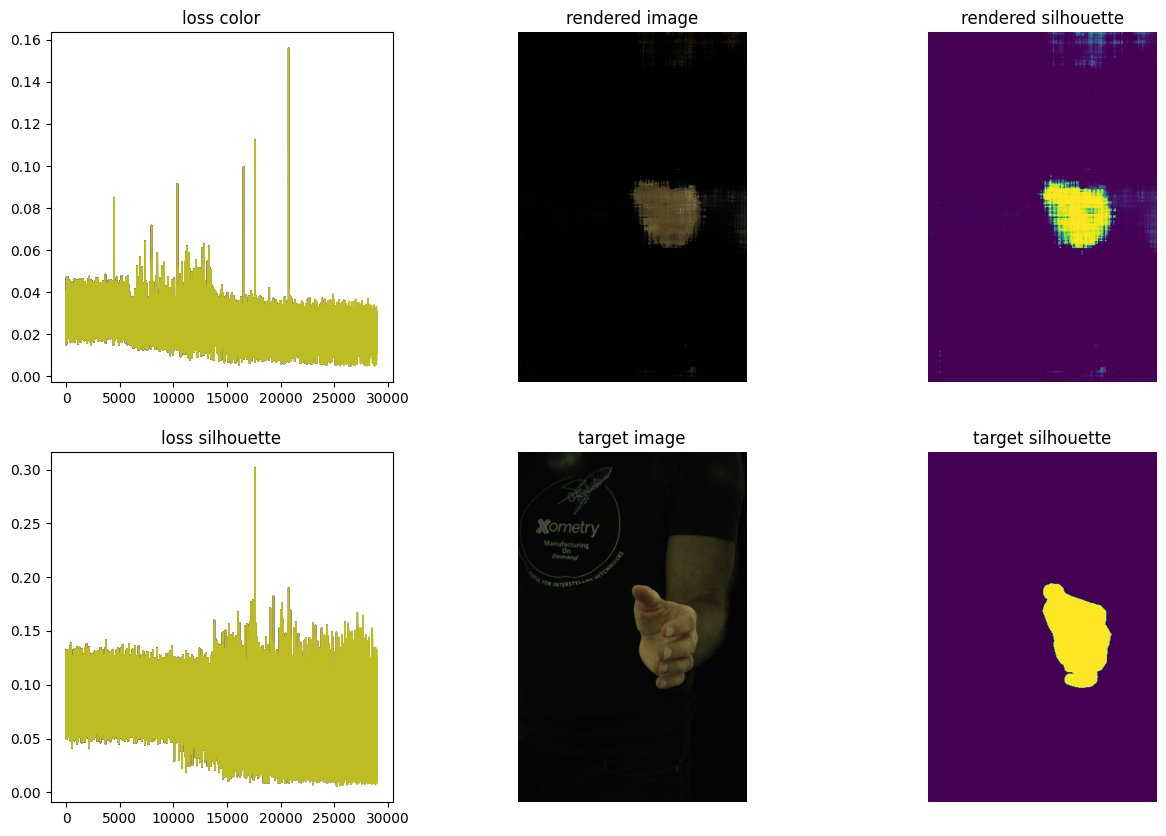

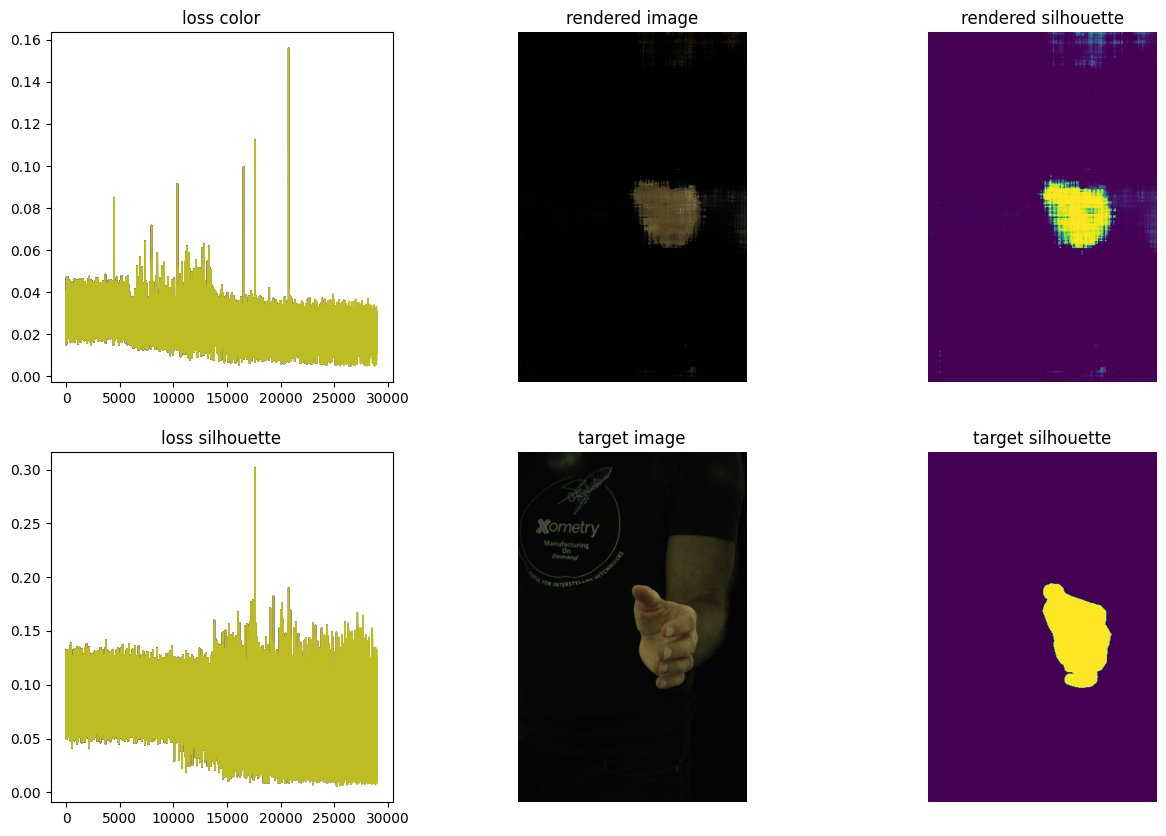

In [16]:
# Init the loss history buffers.
loss_history_color, loss_history_sil = [], []

# The main optimization loop.
pbar = tqdm(range(n_iter))

fig, ax = plt.subplots(2, 3, figsize=(15, 10))

for iteration in pbar:
    # In case we reached the last 75% of iterations,
    # decrease the learning rate of the optimizer 10-fold.

    # if iteration == round(n_iter * 0.5):
    #     print('Decreasing LR 10-fold ...')
    #     optimizer = torch.optim.Adam(
    #         neural_radiance_field.parameters(), lr=lr * 0.1
    #     )

    # Zero the optimizer gradient.
    optimizer.zero_grad()

    # Sample random batch indices.
    batch_idx = torch.randperm(len(target_cameras))[:batch_size]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R=target_cameras.R[batch_idx],
        T=target_cameras.T[batch_idx],
        znear=target_cameras.znear[batch_idx],
        zfar=target_cameras.zfar[batch_idx],
        aspect_ratio=target_cameras.aspect_ratio[batch_idx],
        fov=target_cameras.fov[batch_idx],
        device=device,
    )

    # Evaluate the nerf model.
    rendered_images_silhouettes, sampled_rays = renderer_mc(
        cameras=batch_cameras,
        volumetric_function=neural_radiance_field
    )
    rendered_images, rendered_silhouettes = (
        rendered_images_silhouettes.split([3, 1], dim=-1)
    )

    # Compute the silhouette error as the mean huber
    # loss between the predicted masks and the
    # sampled target silhouettes.
    silhouettes_at_rays = sample_images_at_mc_locs(
        target_silhouettes[batch_idx, ..., None],
        sampled_rays.xys
    )
    sil_err = huber(
        rendered_silhouettes,
        silhouettes_at_rays,
    ).abs().mean()

    # Compute the color error as the mean huber
    # loss between the rendered colors and the
    # sampled target images.
    colors_at_rays = sample_images_at_mc_locs(
        target_images[batch_idx],
        sampled_rays.xys
    )
    color_err = huber(
        rendered_images,
        colors_at_rays,
    ).abs().mean()

    # The optimization loss is a simple
    # sum of the color and silhouette errors.
    loss = color_err + sil_err

    # Log the loss history.
    loss_history_color.append(float(color_err))
    loss_history_sil.append(float(sil_err))

    # Every 10 iterations, print the current values of the losses.
    if iteration % 10 == 0:
        pbar.set_description(
            f'Iteration {iteration:05d}:'
            + f' loss color = {float(color_err):1.2e}'
            + f' loss silhouette = {float(sil_err):1.2e}'
        )

    # Take the optimization step.
    loss.backward()
    optimizer.step()

    # Visualize the full renders every 1000 iterations.
    if iteration and iteration % 1000 == 0:

        show_idx = torch.randperm(len(target_cameras))[:1]
        show_full_render(
            neural_radiance_field,
            FoVPerspectiveCameras(
                R=target_cameras.R[show_idx],
                T=target_cameras.T[show_idx],
                znear=target_cameras.znear[show_idx],
                zfar=target_cameras.zfar[show_idx],
                aspect_ratio=target_cameras.aspect_ratio[show_idx],
                fov=target_cameras.fov[show_idx],
                device=device,
            ),
            target_images[show_idx][0],
            target_silhouettes[show_idx][0],
            loss_history_color,
            loss_history_sil,
            renderer_grid=renderer_grid,
            fig=fig,
            ax=ax,
        )

In [ ]:
import importlib
importlib.reload(neuman_helper)

Rendering rotating NeRF ...


  0%|          | 0/15 [00:00<?, ?it/s]

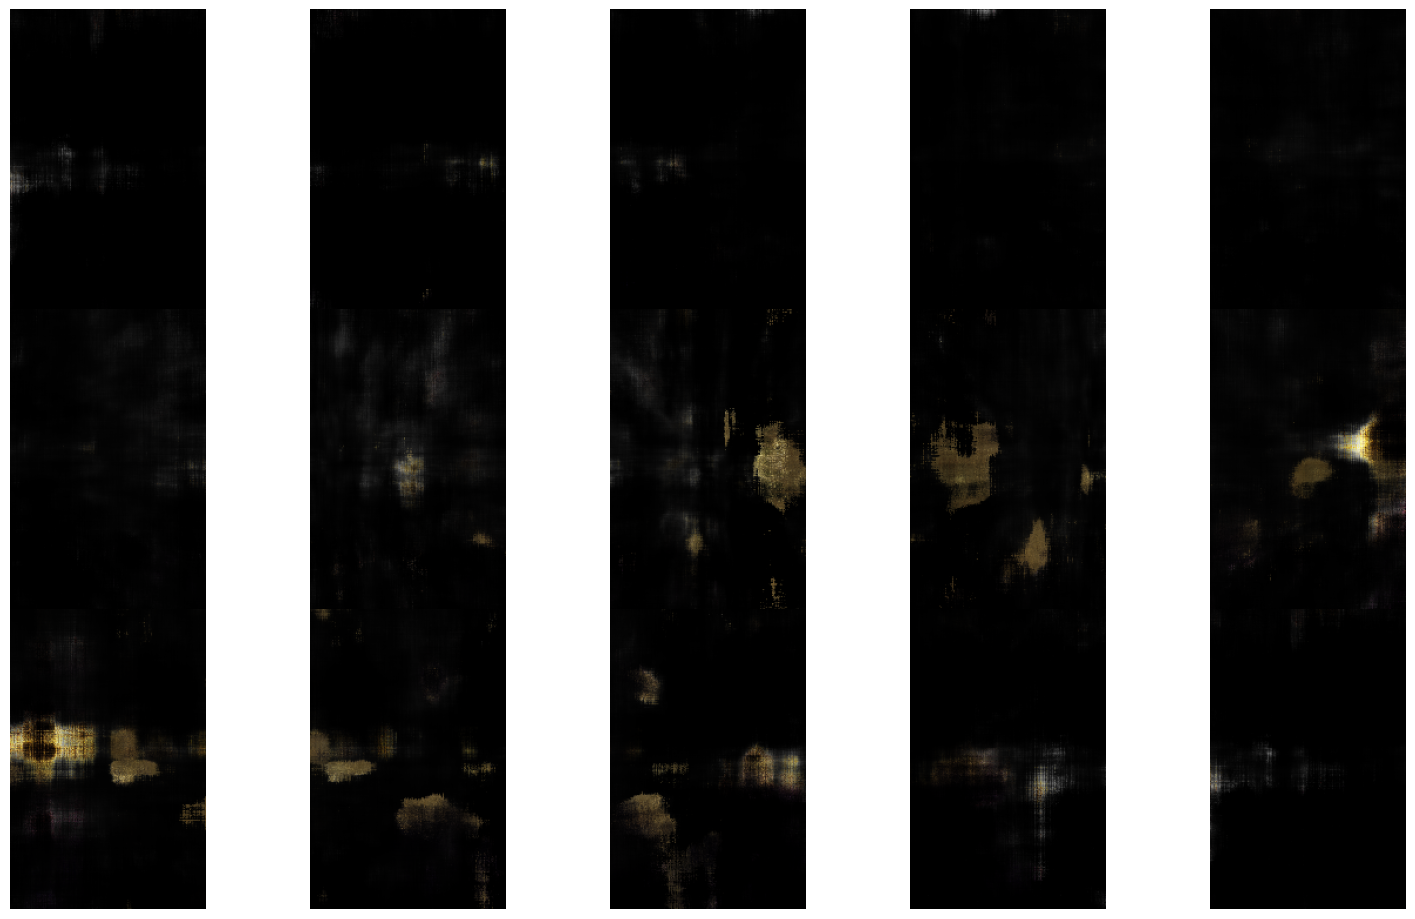

In [17]:
import helpers
import importlib
importlib.reload(helpers)

with torch.no_grad():
    rotating_nerf_frames = helpers.generate_rotating_nerf(neural_radiance_field, target_cameras, renderer_grid, device=device, n_frames=3 * 5)

image_grid(rotating_nerf_frames.clamp(0., 1.).cpu().numpy(), rows=3, cols=5, rgb=True, fill=True)
plt.show()

In [ ]:
torch.cuda.empty_cache()

In [53]:
import torchvision

def plot_results(n_cameras):
    with torch.no_grad():

        # choose a random subset of cameras
        cameras_choice = torch.randperm(len(target_cameras))[:n_cameras]
        images_silhouettes = []

        for camera_index in range(len(cameras_choice)):
            show_idx = cameras_choice[camera_index:camera_index+1]

            camera = FoVPerspectiveCameras(
                R=target_cameras.R[show_idx],
                T=target_cameras.T[show_idx],
                znear=target_cameras.znear[show_idx],
                zfar=target_cameras.zfar[show_idx],
                aspect_ratio=target_cameras.aspect_ratio[show_idx],
                fov=target_cameras.fov[show_idx],
                device=device,
            )
            # Render using the grid renderer and the
            # batched_forward function of neural_radiance_field.
            rendered_image_silhouette, _ = renderer_grid(
                cameras=camera,
                volumetric_function=neural_radiance_field.batched_forward
            )
            # Split the rendering result to a silhouette render
            # and the image render.
            rendered_image, rendered_silhouette = (
                rendered_image_silhouette[0].split([3, 1], dim=-1)
            )

            # concatenate the rendered image and the silhouette.
            # print(rendered_image.shape, rendered_silhouette.shape)
            # convert rendered silhouette to rgb
            rendered_silhouette = torch.cat([rendered_silhouette, rendered_silhouette, rendered_silhouette], dim=-1)

            original_image = target_images[show_idx][0]

            # downscale the original image to the size of the rendered image

            original_image = original_image.permute(2, 0, 1)

            original_image = torch.nn.functional.interpolate(original_image[None, ...], size=rendered_image.shape[:2], mode='bilinear', align_corners=False)[0]

            original_image = original_image.permute(1, 2, 0)



            # print(original_image.shape)


            concatenated = torch.cat([
                # original_image,
                rendered_image,
                rendered_silhouette
            ], dim=1)
            # transpose (H, W, C) to pytorch image format
            concatenated = concatenated.permute(2, 0, 1)
            images_silhouettes.append(
                concatenated
                                      )


    grid = torchvision.utils.make_grid(images_silhouettes, nrow=5)

    # plot the grid
    plt.figure(figsize=(15, 15))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

plot_results(10)

<IPython.core.display.Javascript object>

In [54]:
# make eaxmple plot
import matplotlib.pyplot as plt
import numpy as np

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 15))

# plot the image
ax1.imshow(target_images[0].cpu().numpy())
ax1.axis('off')

# plot the silhouette
ax2.imshow(target_silhouettes[0].cpu().numpy())
ax2.axis('off')

plt.show()

<IPython.core.display.Javascript object>

In [50]:
plot_results(10)

<IPython.core.display.Javascript object>

In [ ]:
# plot target_cameras.T in 3d
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

cam_poses = target_cameras.get_camera_center().cpu().numpy()
# cam_poses
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# use index of cameras as markers
for i in range(len(cam_poses)):
    ax.scatter(cam_poses[i, 0], cam_poses[i, 1], cam_poses[i, 2], marker=f'${i}$')



In [ ]:
neural_radiance_field(0, 0, 0)

In [19]:
with torch.no_grad():

    batch_idx = torch.randperm(len(target_cameras))[:6]

    # Sample the minibatch of cameras.
    batch_cameras = FoVPerspectiveCameras(
        R=target_cameras.R[batch_idx],
        T=target_cameras.T[batch_idx],
        znear=target_cameras.znear[batch_idx],
        zfar=target_cameras.zfar[batch_idx],
        aspect_ratio=target_cameras.aspect_ratio[batch_idx],
        fov=target_cameras.fov[batch_idx],
        device=device,
    )

    ray_bundle = raysampler_grid(batch_cameras)

    from pytorch3d.renderer import ray_bundle_to_ray_points
    rays_points_world = ray_bundle_to_ray_points(ray_bundle).cpu().numpy().reshape(-1, 3)[::]

    print(ray_bundle.origins.shape, ray_bundle.directions.shape)

    # ray_bundle = RayBundle(
    #                     origins=ray_bundle.origins.reshape(-1, 3)[::1000],
    #                     directions=ray_bundle.directions.reshape(-1, 3)[::1000],
    #                     lengths=ray_bundle.lengths.reshape(-1, 32)[::1000],
    #                     xys=None,
    #                 )


    opacity, color = neural_radiance_field.batched_forward(ray_bundle)
    print(opacity.shape, color.shape)

    opacity = opacity.cpu().numpy().reshape(-1, 1)[::]
    color = color.cpu().numpy().reshape(-1, 3)[::]

    print(opacity.shape, color.shape)

    # get indices of opacities > 0.001
    opacity_indices = np.where(opacity > 0.001)[0]
    non_white = np.where(np.linalg.norm(color, axis=1) < 0.99)[0]


    # how many opacities are > 0.001?
    print('opacity_indices', len(opacity_indices))
    # print('color', color.shape)

    # # get norm of color
    # color_norm = np.linalg.norm(color, axis=1)
    #
    # print('color_norm', color_norm.shape)

    # which points have non-white color?
    # non_white = np.where(
    #     color_norm[opacity_indices] < 0.99
    # )[0]
    print('non_white', len(non_white))

    indices_both = np.intersect1d(opacity_indices, non_white)

    print('indices_both', len(indices_both))

    # plot ray_bundle.origins + ray_bundle.directions as 3d points
    %matplotlib notebook
    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    import numpy as np

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # visualize ray_points_world with color and opacity, where opacity > 0.001
    ax.scatter(rays_points_world[indices_both, 0], rays_points_world[indices_both, 1], rays_points_world[indices_both, 2], c=color[indices_both, :], alpha=opacity[indices_both, :])



torch.Size([6, 256, 167, 3]) torch.Size([6, 256, 167, 3])
torch.Size([6, 256, 167, 32, 1]) torch.Size([6, 256, 167, 32, 3])
(8208384, 1) (8208384, 3)
opacity_indices 2008994
non_white 188487
indices_both 165492


<IPython.core.display.Javascript object>

In [40]:
animations = []
with torch.no_grad():
    for camera_id in range(10):
        n_frames = 30

        # logRs = torch.zeros(n_frames, 3, device=device)
        # logRs[:, 1] = torch.linspace(-3.14, 3.14, n_frames, device=device)
        # Rs = so3_exp_map(logRs)
        #
        # Ts = torch.zeros(n_frames, 3, device=device)
        # Ts[:, 2] = 2.7
        # Ts[:, 1] = torch.cos(torch.linspace(0, 3.14, n_frames, device=device))
        # Ts[:, 0] = torch.sin(torch.linspace(0, 3.14, n_frames, device=device))

        # Rs = torch.ra

        # camera_id = 9
        R=target_cameras.R[camera_id:camera_id+1]
        T=target_cameras.T[camera_id:camera_id+1]

        # generate camera trajectory using R and T
        # Rs = so3_exp_map(torch.linspace(0, 3.14, n_frames, device=device)[:, None, None] * R)

        # copy R n_frames times
        Rs = torch.repeat_interleave(R, n_frames, dim=0)

        # create Ts by rotating around T
        Ts = torch.zeros(n_frames, 3, device=device)
        Ts[:, 2] = 2.7 * torch.cos(torch.linspace(-3.14, 3.14, n_frames, device=device))
        # Ts[:, 1] = torch.cos(torch.linspace(-3.14, 3.14, n_frames, device=device))
        # Ts[:, 0] = torch.sin(torch.linspace(-3.14, 3.14, n_frames, device=device))
        Ts = Ts + T



        frames = []
        print('Rendering rotating NeRF ...')
        for R, T in zip(tqdm(Rs), Ts):
            camera = FoVPerspectiveCameras(
                R=R[None],
                T=T[None],
                znear=target_cameras.znear[0],
                zfar=target_cameras.zfar[0],
                aspect_ratio=target_cameras.aspect_ratio[0],
                fov=target_cameras.fov[0],
                device=device,
            )
            # Note that we again render with `NDCMultinomialRaysampler`
            # and the batched_forward function of neural_radiance_field.
            frames.append(
                renderer_grid(
                    cameras=camera,
                    volumetric_function=neural_radiance_field.batched_forward,
                )[0][0][..., :3].cpu().numpy()
            )

    # show frames as gif
        from IPython.display import HTML
        from matplotlib import animation

        fig = plt.gcf()
        plt.axis('off')
        ims = [[plt.imshow(frame, animated=True)] for frame in frames]
        ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                        repeat_delay=100)

        # plt.clf()
        vid = HTML(ani.to_jshtml())
        animations.append(vid)

        display(vid)
        break
    # plt.clf()


Rendering rotating NeRF ...


  0%|          | 0/30 [00:00<?, ?it/s]

In [32]:
# display animations in a grid
from IPython.display import display, HTML

for i in animations:
    display(i)

In [ ]:
torch.cuda.empty_cache()